As a default limb darkening, TLS uses the quadratic law with parameters $a, b =[0.4804, 0.1867]$ from a sun-like G2V star. This was derived from the average transit curve (see paper Figure 2). Equivalently, we can plot the host star temperature of all known exoplanets. The mode of this distribution is $\sim5800\,$K, comparable to the sun: <img src="https://github.com/hippke/tls/blob/master/images/fig_histo_teff.png?raw=true">

This default works in so far that most LDs will not be that for of in practice. But let's look at one such example where the default and the real LDs are maximally different. The most extreme example I could find is for K2-97 [(Grunblatt+ 2016)](https://ui.adsabs.harvard.edu/#abs/arXiv:1606.05818), a Hot Jupiter orbiting a Red Giant Star ($R_*=4.20\pm0.14 R_{\odot}$). First, we pull the catalog priors:

In [1]:
from transitleastsquares import transitleastsquares, catalog_info, cleaned_array
EPIC_id = 211351816
ab, mass, mass_min, mass_max, radius, radius_min, radius_max = catalog_info(EPIC_id)
print('Stellar mass', mass)
print('Stellar radius', radius)
print('Quadratic LD parameters (a,b)=', ab)

/home/michael/.local/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


Stellar mass 1.219
Stellar radius 7.357
Quadratic LD parameters (a,b)= (0.5591, 0.2983)


From [(Grunblatt+ 2016)](https://ui.adsabs.harvard.edu/#abs/arXiv:1606.05818), we get slightly less extreme values: $(a,b)=[0.6505, 0.1041]$ for $T_{\rm eff}=4790\,$K, log$\,g=3.26$. But how much do the 3 variants differ in praxis? Let's plot them!

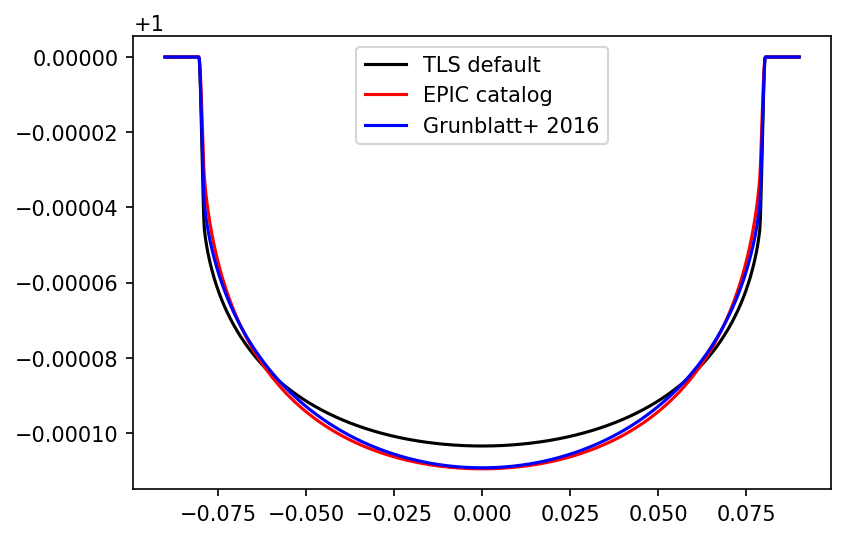

In [2]:
import numpy
import batman
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.dpi"] = 150

def transit(ld):  # Use batman to create transits
    ma = batman.TransitParams()
    ma.t0 = 0  # time of inferior conjunction; first transit is X days after start
    ma.per = 10  # orbital period
    ma.rp = 6371 / 696342  # 6371 planet radius (in units of stellar radii)
    ma.a = 20  # semi-major axis (in units of stellar radii)
    ma.inc = 90  # orbital inclination (in degrees)
    ma.ecc = 0  # eccentricity
    ma.w = 90  # longitude of periastron (in degrees)
    ma.u = ld  # limb darkening coefficients
    ma.limb_dark = "quadratic"  # limb darkening model
    m = batman.TransitModel(ma, time)  # initializes model
    return m.light_curve(ma)

# Plot raw data
time = numpy.linspace(-0.09, 0.09, 1000)
plt.figure()
ax = plt.gca()
ax.plot(time, transit(ld=[0.4804, 0.1867]), color='black', label='TLS default')
ax.plot(time, transit(ld=ab), color='red', label='EPIC catalog')
ax.plot(time, transit(ld=[0.6505, 0.1041]), color='blue', label='Grunblatt+ 2016')
plt.legend();

We can clearly see that the TLS default (black line) is quite a bit off from the two others. The catalog value and the Grundblatt+ (2016) estimate, however, are close. Considerung realistic Kepler K2 noise, one might tend to believe that the TLS default template could result in a slightly worse fit, but the EPIC catalog would be "good enough". We now run a TLS search for both versions and compare the signal detection efficiency (SDE). To shorten this tutorial, we skip over the detrending details - these turn out to be very robust.

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 211351816.
Transit Least Squares TLS 1.0.7 (04 January 2019)
Creating model cache for 35 durations
Searching 3405 data points, 7790 periods from 0.601 to 36.992 days, using all 8 CPU threads


100%|██████████| 7790/7790 periods | 00:08<00:00  
 41%|████      | 1388/3371 [00:00<00:03, 591.98it/s]

Searching for best T0 for period 8.40612


100%|██████████| 3371/3371 [00:00<00:00, 9678.78it/s]


Signal detection efficiency (SDE), TLS default LDs: 20.45004
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos


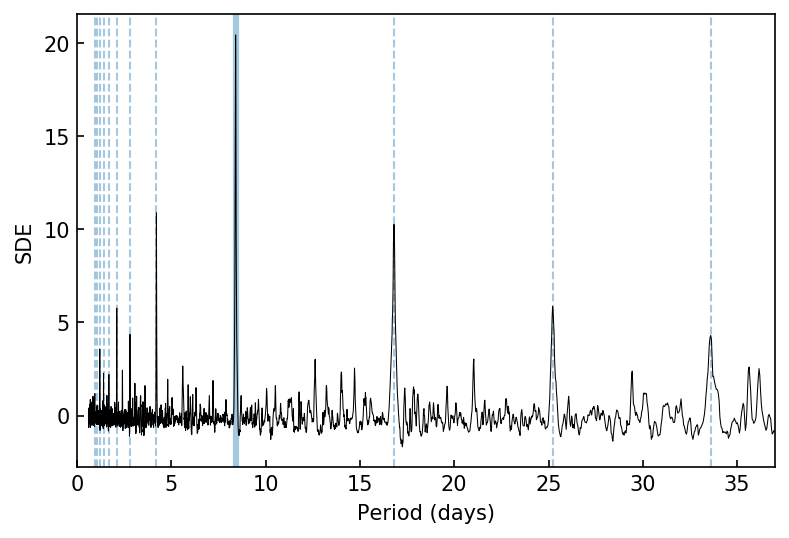

In [3]:
import everest
import scipy
from astropy.stats import sigma_clip

star = everest.Everest(EPIC_id)
t = numpy.delete(star.time, star.badmask)
y = numpy.delete(star.fcor, star.badmask)
t = numpy.array(t[~numpy.isnan(y)], dtype='float32')
y = numpy.array(y[~numpy.isnan(y)], dtype='float32')

trend = scipy.signal.medfilt(y, 101)
y_filt = y /trend
y_filt = sigma_clip(y_filt, sigma_upper=3, sigma_lower=99)
t, y_filt = cleaned_array(t, y_filt)

model = transitleastsquares(t, y_filt)
results = model.power()
print('Signal detection efficiency (SDE), TLS default LDs:', format(results.SDE, '.5f'))

plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods));

That's a highly significant signal. Let's see the phases-folded data:

DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos


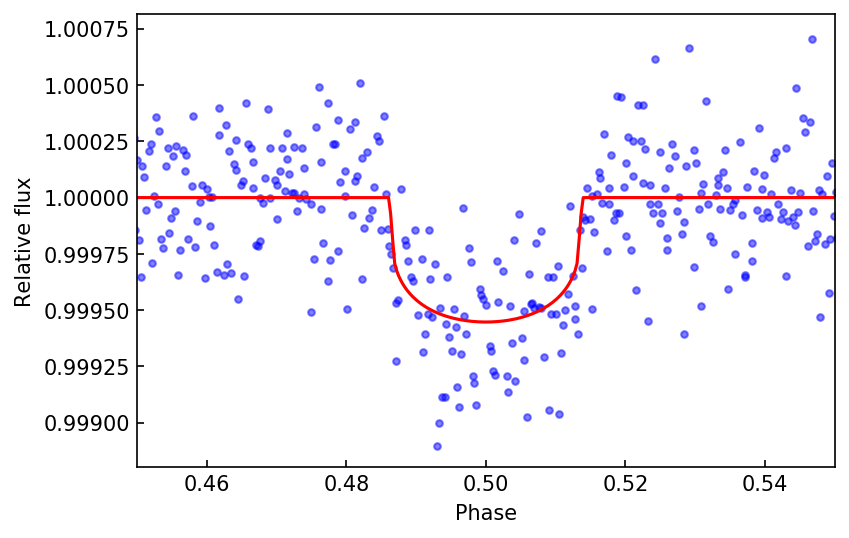

In [4]:
plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.45, 0.55)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

That certainly looks like a transit, but the LD parameters will probably make not much of a difference at this noise level. Still, we can compare their effect:

In [5]:
model = transitleastsquares(t, y_filt)
results = model.power(limb_dark='quadratic', u=ab)
print('Signal detection efficiency (SDE), catalog value LDs:', format(results.SDE, '.5f'))

model = transitleastsquares(t, y_filt)
results = model.power(limb_dark='quadratic', u=[0.6505,0.1041])
print('Signal detection efficiency (SDE), Grunblatt+ (2016) LDs:', format(results.SDE, '.5f'))

Transit Least Squares TLS 1.0.7 (04 January 2019)
Creating model cache for 35 durations
Searching 3405 data points, 7790 periods from 0.601 to 36.992 days, using all 8 CPU threads


100%|██████████| 7790/7790 periods | 00:08<00:00  
 36%|███▌      | 1201/3371 [00:00<00:00, 12008.15it/s]

Searching for best T0 for period 8.40612


100%|██████████| 3371/3371 [00:00<00:00, 13010.87it/s]

Signal detection efficiency (SDE), catalog value LDs: 20.51699
Transit Least Squares TLS 1.0.7 (04 January 2019)
Creating model cache for 35 durations
Searching 3405 data points, 7790 periods from 0.601 to 36.992 days, using all 8 CPU threads



100%|██████████| 7790/7790 periods | 00:08<00:00  
 68%|██████▊   | 2294/3371 [00:00<00:00, 10857.63it/s]

Searching for best T0 for period 8.40612


100%|██████████| 3371/3371 [00:00<00:00, 11914.57it/s]

Signal detection efficiency (SDE), Grunblatt+ (2016) LDs: 20.48274


To summarize the SDEs:
- 20.45004 with the TLS default (the worst)
- 20.51699 with the EPIC catalog values
- 20.48274 with the Grundblatt+ 2016 values (probably the best)

As expected, at this noise level it doesn't make much of a difference. Still, *on average* when searching thousands of light curves, it will make a difference! So if we have priors that are better than nothing, then we should use them. Let me know what your experience is...perhaps there is an example out there better suited for this tutorial.

Transit Least Squares TLS 1.0.7 (04 January 2019)
Creating model cache for 35 durations
Searching 3405 data points, 7790 periods from 0.601 to 36.992 days, using all 8 CPU threads


100%|██████████| 7790/7790 periods | 00:08<00:00  
 40%|███▉      | 1336/3371 [00:00<00:00, 13356.26it/s]

Searching for best T0 for period 8.40612


100%|██████████| 3371/3371 [00:00<00:00, 13455.69it/s]

Signal detection efficiency (SDE), catalog value LDs: 20.60923
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos


DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos


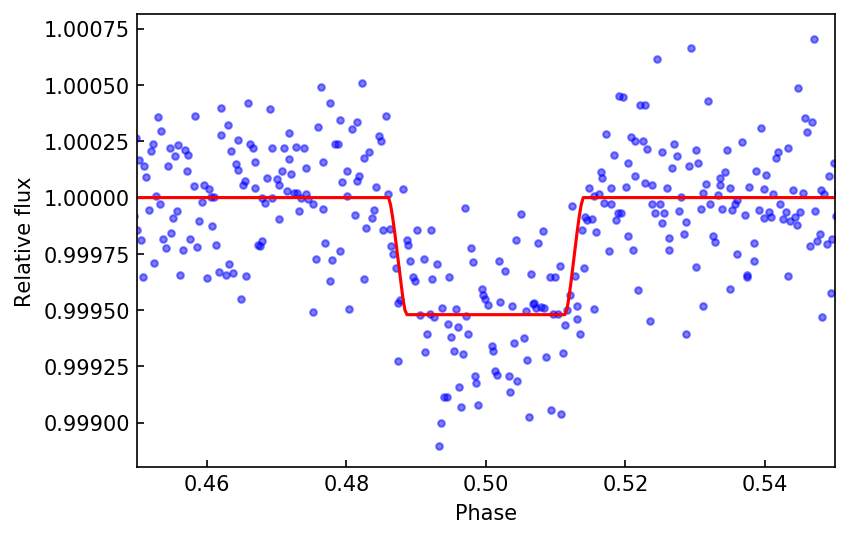

In [6]:
model = transitleastsquares(t, y_filt)
results = model.power(limb_dark='quadratic', u=ab, transit_template='box')
print('Signal detection efficiency (SDE), catalog value LDs:', format(results.SDE, '.5f'))
plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.45, 0.55)
plt.xlabel('Phase')
plt.ylabel('Relative flux');